In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
input_shape = (128, 128, 3)
data_dir = 'dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
#on interation 9 the test size was moved to 0.1 from 0.2
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=5)


In [3]:
print(len(X_train))
print(len(X_val))

39720
4414


In [4]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

'''
models = [model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                  metrics=['accuracy']),
         model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=1e-6, beta_1=0.85, beta_2=0.999, epsilon=1e-3, decay=0.0, amsgrad=False),
                  metrics=['accuracy']),
         model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=2.5e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
                  metrics=['accuracy']),
         model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.9999, epsilon=1e-5, decay=0.0, amsgrad=False),
                  metrics=['accuracy'])]

'''
iteration = 10
#iterations past 4 use lr=1e-4, beta_1=0.9, beta_2=0.9999, epsilon=1e-5, decay=0.0, amsgrad=False
googleNet_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.9999, epsilon=1e-5, decay=0.0, amsgrad=False),
                  metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [5]:
#Currently not used
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
#BATCH_SIZE = 100
BATCH_SIZE = 256
# iteration 6 switched to batch size of 256
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 39720 samples, validate on 4414 samples
Epoch 1/20
39720/39720 [==============================] - 230s 6ms/sample - loss: 0.2498 - acc: 0.8984 - val_loss: 0.7647 - val_acc: 0.8430
Epoch 2/20
39720/39720 [==============================] - 203s 5ms/sample - loss: 0.0639 - acc: 0.9775 - val_loss: 0.1439 - val_acc: 0.9515
Epoch 3/20
39720/39720 [==============================] - 203s 5ms/sample - loss: 0.0313 - acc: 0.9889 - val_loss: 0.1129 - val_acc: 0.9642
Epoch 4/20
39720/39720 [==============================] - 202s 5ms/sample - loss: 0.0262 - acc: 0.9906 - val_loss: 0.1105 - val_acc: 0.9662
Epoch 5/20
39720/39720 [==============================] - 204s 5ms/sample - loss: 0.0146 - acc: 0.9951 - val_loss: 0.1178 - val_acc: 0.9694
Epoch 6/20
39720/39720 [==============================] - 205s 5ms/sample - loss: 0.0120 - acc: 0.9959 - val_loss: 0.1509 - val_acc: 0.9610
Epoch 7/20
39720/

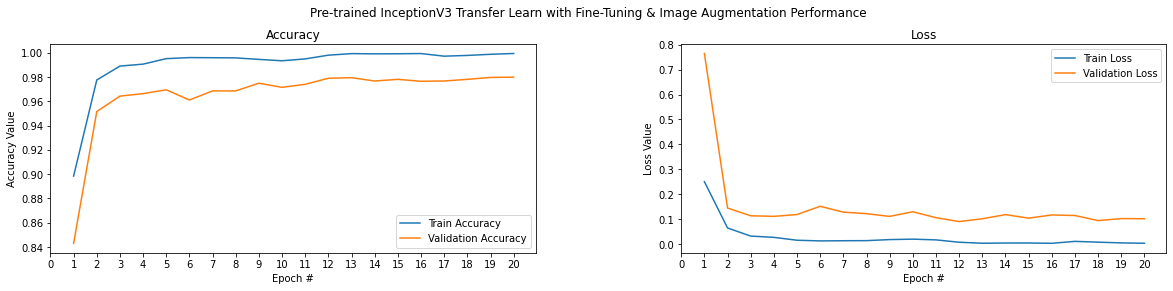

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionV3 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")


In [7]:
#iteration = 1
os.mkdir('iter' + str(iteration))
os.chdir('iter' + str(iteration))
f.savefig('iter-' + str(iteration) + '.png')

True positive =  35518
False positive =  45
False negative =  55
True negative =  8516




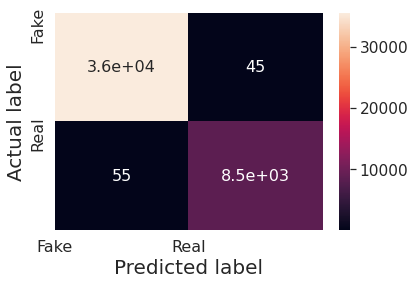

In [8]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    fig = plt.figure()
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    fig.savefig('confusion-iter' + str(iteration)+'.png')
    plt.show()
    
    
print_confusion_matrix(Y_val_org, model.predict_classes(X))

In [9]:
model.save('deepfake-detection-model.h5')
f = open('dataset-sizes.txt','a')
f.write("Train set number of samples ")
f.write(str(X_train.shape[0]))
f.write("Test set number of samples ")
f.write(str(X_val.shape[0]))
f.close()
os.chdir('../')